# Time Series Momentum Strategy - G9 Currencies 

In [1]:
import pandas as pd
import numpy  as  np
from datetime import datetime, timedelta

### 1. Data Download 

In [2]:
fx_df = pd.read_csv("G10_FX_HI_LO_CLOSE.csv", skiprows=0, header = None)

## 2. Data Split

In [3]:
train_size = int(fx_df.shape[0] * 0.8)

In [4]:

i = 1 
while (i < fx_df.shape[1]):
    columns_list = [0]
    columns_list.append(i)
    for j in range(i+1,fx_df.shape[1],1):
        if (fx_df[i][0] == fx_df[j][0]):
            columns_list.append(j)
            if (j == fx_df .shape[1]-1):
                df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
                df_["Dates"] = pd.to_datetime(df_["Dates"])
                df_.set_index("Dates")
                df_.columns = ["Dates","High","Low","Last"]
                df_.to_csv(f'FX_{fx_df[i][0]}.csv')
                break
            
        else:
            df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
            df_["Dates"] = pd.to_datetime(df_["Dates"])
            df_.set_index("Dates")
            df_.columns = ["Dates","High","Low","Last"]
            df_.to_csv(f'FX_{fx_df[i][0]}.csv')
            break
    

    if ( j == fx_df.shape[1]-1):
        break
    else:
        i = j 
        columns_list.clear()

## 2. Data Frame for the list of currencies - Training Data set 

In [5]:
FX_SEK =  pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_DKK =  pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_CHF =  pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_NZD =  pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_AUD =  pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_CAD=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_GBP=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_JPY = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_EUR = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]

## 3. Data Frame for the list of currencies - for Validation of portfolio PNL

In [6]:
FX_SEK_validation =  pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_DKK_validation =  pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_CHF_validation =  pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_NZD_validation =  pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_AUD_validation =  pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_CAD_validation=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_GBP_validation=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_JPY_validation = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_EUR_validation = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]

## 4. main database of all the G9 currency  

In [7]:
all_df = [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_CAD,FX_GBP,FX_JPY,FX_EUR]

## 4. DataFrame - CLose Price of all the G9 currency pairs 

In [ ]:
close_df = pd.concat([FX_SEK["Last"],FX_DKK["Last"],FX_CHF["Last"],FX_NZD["Last"] ,FX_AUD["Last"],FX_CAD["Last"],FX_GBP["Last"],FX_JPY["Last"],FX_EUR["Last"]],axis =1)

close_df.columns = {"FX_SEK","FX_DKK","FX_CHF","FX_NZD","FX_AUD","FX_CAD","FX_GBP","FX_JPY","FX_EUR"}

available_symbols = close_df.columns

In [25]:
close_df.shape

(2187, 9)

# 5. TSMOM strategy -

## 5.1 Function to generate Trend Signal 

In [18]:
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    print(Close_price.shape)
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)

## 5.2 Function to Volatility 

In [19]:
def GetYZVolatility(all_df):

    """ Formula: sigma_YZ^2 = sigma_OJ^2 + self.k * sigma_SD^2 + (1-self.k)*sigma_RS^2 (Equation 20 in [1])
        where,  sigma_OJ - (Overnight Jump Volitility estimator)
                sigma_SD - (Standard Volitility estimator)
                sigma_RS - (Rogers and Satchell Range Volatility estimator)"""
    
    YZ_volatility = []
    for i,j in enumerate(all_df):
        today = pd.to_datetime(all_df[i].index[-1]).strftime('%Y-%m-%d')
        diff = pd.to_datetime(pd.to_datetime(all_df[i].index[-1]) - timedelta(32)).strftime('%Y-%m-%d')
        past_month_ohlc = all_df[i].loc[diff:today]
        high,low,close,open = past_month_ohlc.High,past_month_ohlc.Low, past_month_ohlc.Last,past_month_ohlc.Last
        estimation_period = past_month_ohlc.shape[0]
        k = 0.34 / (1.34 + (estimation_period + 1) / (estimation_period - 1))


        #sigma_OJ (overnight jump => stdev of close-to-open log returns)
        open_to_close_log_returns = np.log(close / close.shift(1))
        open_to_close_log_returns = open_to_close_log_returns[np.isfinite(open_to_close_log_returns)]
        sigma_OJ = np.std(open_to_close_log_returns)

        # sigma_SD (standard deviation of close-to-close log returns)
        close_to_close_log_returns = np.log(close / close.shift(1))
        close_to_close_log_returns = close_to_close_log_returns[np.isfinite(close_to_close_log_returns)]
        sigma_SD = np.std(close_to_close_log_returns)

        # sigma_RS (Rogers and Satchell (1991))
        h = np.log(high / open)
        l = np.log(low / open)
        c = np.log(close / open)
        sigma_RS_daily = (h * (h - c) + l * (l - c)) ** 0.5
        sigma_RS_daily = sigma_RS_daily[np.isfinite(sigma_RS_daily)]
        sigma_RS = np.mean(sigma_RS_daily)

        # daily Yang and Zhang volatility
        sigma_YZ = np.sqrt(sigma_OJ ** 2 + k * sigma_SD ** 2 + (1 - k) * sigma_RS ** 2)

        # append annualized volatility to the list
        YZ_volatility.append(sigma_YZ * np.sqrt(252))


       
    return YZ_volatility

## 5.3 Function to determine correlation factor between different Currencies 

In [20]:
def GetCorrelationFactor(history,trade_signals,available_symbols):
    '''
    Correlation Factor, is a function of the average pairwise correlation of all portfolio contituents
    - the calculation is based on past three month pairwise correlation
    - Notations:
        rho_bar - average pairwise correlation of all portfolio constituents
        CF_rho_bar - the correlation factor as a function of rho_bar'''

    # Get the past three month simple daily returns for all securities
    diff = pd.to_datetime(pd.to_datetime(close_df.index[-1]) - timedelta(90)).strftime('%Y-%m-%d')
    past_three_month_returns = close_df.pct_change().loc[diff:]
    past_three_month_returns.corr()
    
    # Get number of assets 
    N_assets = len(available_symbols)

    # Get the pairwise signed correlation matrix for all assets
    correlation_matrix = past_three_month_returns.corr()

    # Calculate rho_bar
    summation = 0
    for i in range(N_assets - 1):
        for temp in range(N_assets - 1 - i):
            j = i + temp + 1
            x_i = trade_signals.values[i]
            x_j = trade_signals.values[j]
            rho_i_j = correlation_matrix.iloc[i, j]
            summation += x_i * x_j * rho_i_j

    # Equation 14 in [1]
    rho_bar = (2 * summation) / (N_assets * (N_assets - 1))

    # Calculate the correlation factor (CF_rho_bar)
    # Equation 18 in [1]
    return np.sqrt(N_assets / (1 + (N_assets - 1) * rho_bar)) 

## 5.4 Function to generate portfolio weights for different currency  
-  weights allocation is based on  volaiity 
-  Also have considered correlation factor 

In [21]:
from sklearn.preprocessing import StandardScaler
def Portfolio_Creation(close_df,all_df,available_symbols,portfolio_target_sigma):
    
    #print (history.head(5))
    N_assets = len(available_symbols)
    AssetWeight = []
    '''
    Monthly rebalance at the beginning of each month.
    Portfolio weights for each constituents are calculated based on Baltas and Kosowski weights.
    '''

    '''Monthly Rebalance Execution'''
    """
    # dataframe that contains the historical data for all securities
    history = self.History(self.Securities.Keys, self.OneYear, Resolution.Daily)
    history.replace(0, np.nan, inplace=True)

    # Get the security symbols are are in the history dataframe
    available_symbols = list(set(history.index.get_level_values(level=0)))

    # Liquidate symbols that are not in the history dataframe anymore
    for security in self.Securities.Keys:
        if security.Value not in available_symbols:
            self.Liquidate(security, 'Not found in history request')
    """
    # Get the trade signals and YZ volatility for all securities
    print(close_df)
    trade_signals = GetTradingSignal(close_df)
    print("trade_signals")
    print(trade_signals)
    
    TopCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).head(3)
    BottomCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).tail(3)
    FX_Pairs_Portfolio = list(pd.concat([TopCurrency , BottomCurrency]).index)
    #'FX_CHF', 'FX_DKK', 'FX_AUD', 'FX_GBP', 'FX_NZD', 'FX_SEK']
    
    all_df1 = [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_GBP]
    volatility =  GetYZVolatility(all_df1)   
    
    close_df = close_df[FX_Pairs_Portfolio]
    available_symbols = FX_Pairs_Portfolio
    trade_signals = pd.concat([TopCurrency , BottomCurrency])
    
    # Get the correlation factor
    CF_rho_bar = GetCorrelationFactor(close_df, trade_signals, available_symbols)
    # Rebalance the portfolio according to Baltas and Kosowski suggested weights
    N_assets = len(available_symbols)
    symbol_port = []
    weight_port = []
    final_Normalized_weight = []
    for symbol, signal, vol in zip(available_symbols, trade_signals.values, volatility):

        # Baltas and Kosowski weights (Equation 19 in [1])
        print
        weight = (signal * portfolio_target_sigma * CF_rho_bar) / (N_assets * vol)
        symbol_port.append(symbol)
        weight_port.append(weight)
        
        #SetHoldings(symbol, weight)

    # Set next rebalance time
    #self.nextRebalance = Expiry.EndOfMonth(self.Time)
    data = StandardScaler().fit_transform(weight_port)
    for i,j in zip(symbol_port,data):
        final_Normalized_weight.append([i,j])
    
    return final_Normalized_weight

## Weights Allocated to different Currencies : T =0 

In [24]:
close_df.shape

(2187, 9)

In [22]:
Portfolio_Creation(close_df,all_df,available_symbols,0.4)

            FX_EUR  FX_NZD  FX_CHF  FX_AUD  FX_JPY  FX_CAD  FX_DKK  FX_SEK  \
Dates                                                                        
2011-03-01  6.7004  5.5788  0.9334  0.7734  1.0168  0.9938  1.5489  1.3361   
2011-04-01  6.7233  5.6006  0.9486  0.7666  1.0051  0.9983  1.5587  1.3308   
2011-05-01  6.7635  5.6673  0.9659  0.7571  0.9995  0.9956  1.5515  1.3149   
2011-06-01  6.8640  5.7300  0.9655  0.7566  0.9944  0.9966  1.5473  1.3003   
2011-07-01  6.9374  5.7719  0.9673  0.7598  0.9959  0.9935  1.5548  1.2907   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2019-05-15  9.6001  6.6660  1.0087  0.6564  0.6928  1.3438  1.2845  1.1201   
2019-05-16  9.6373  6.6826  1.0100  0.6536  0.6892  1.3460  1.2798  1.1174   
2019-05-17  9.6417  6.6927  1.0110  0.6519  0.6868  1.3458  1.2724  1.1158   
2019-05-20  9.6597  6.6891  1.0086  0.6534  0.6908  1.3429  1.2726  1.1166   
2019-05-21  9.6569  6.6920  1.0111  0.6507  0.6883  1.3406  1.27

[['FX_EUR', array([0.74045378])],
 ['FX_CAD', array([1.32801652])],
 ['FX_NZD', array([0.87325252])],
 ['FX_GBP', array([-0.87674457])],
 ['FX_DKK', array([-0.92117486])],
 ['FX_JPY', array([-1.14380339])]]

In [180]:
TopCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).head(3)
BottomCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).tail(3)
z = pd.concat([TopCurrency , BottomCurrency])
z.values[1]

array([1.])

In [181]:
for i in [ FX_SEK_validation,FX_CHF_validation,FX_NZD_validation,FX_AUD_validation,FX_CAD_validation, FX_GBP_validation,FX_JPY_validation,FX_EUR_validation]:
    today = pd.to_datetime(i.index[1]).strftime('%Y-%m-%d')
    add = pd.to_datetime(pd.to_datetime(i.index[1]) + timedelta(32)).strftime('%Y-%m-%d')
    x = FX_SEK_validation.loc[today:add]

In [182]:
today = pd.to_datetime(FX_SEK_validation.index[1]).strftime('%Y-%m-%d')
add = pd.to_datetime(pd.to_datetime(FX_SEK_validation.index[1]) + timedelta(69)).strftime('%Y-%m-%d')
FX_DKK_F1M = FX_DKK_validation["Last"].loc[today:add]
FX_SEK_F1M = FX_SEK_validation["Last"].loc[today:add]
FX_CHF_F1M = FX_CHF_validation["Last"].loc[today:add]
FX_NZD_F1M = FX_NZD_validation["Last"].loc[today:add]
#FX_CAD_F1M = FX_CAD_validation["Last"].loc[today:add]
FX_AUD_F1M = FX_AUD_validation["Last"].loc[today:add]
#FX_JPY_F1M = FX_JPY_validation["Last"].loc[today:add]
FX_GBP_F1M = FX_GBP_validation["Last"].loc[today:add]
#FX_EUR_F1M = FX_EUR_validation["Last"].loc[today:add]

In [183]:
#OneMonth = pd.concat([FX_SEK_F1M,FX_CHF_F1M,FX_NZD_F1M,FX_CAD_F1M,FX_AUD_F1M,FX_JPY_F1M,FX_GBP_F1M,FX_EUR_F1M],axis =1)
#OneMonth.columns = ["FX_SEK_F1M","FX_CHF_F1M","FX_NZD_F1M","FX_CAD_F1M","FX_AUD_F1M","FX_JPY_F1M","FX_GBP_F1M","FX_EUR_F1M"]
OneMonth = pd.concat([FX_DKK_F1M,FX_SEK_F1M,FX_CHF_F1M,FX_NZD_F1M,FX_AUD_F1M,FX_GBP_F1M],axis =1)
OneMonth.columns = ["FX_DKK_F1M","FX_SEK_F1M","FX_CHF_F1M","FX_NZD_F1M","FX_AUD_F1M","FX_GBP_F1M"]

In [184]:
Daily_PNL = []
Cumulative_PNL = []
cumulativePNL = 0
OneMonth.columns = ["FX_DKK_F1M","FX_SEK_F1M","FX_CHF_F1M","FX_NZD_F1M","FX_AUD_F1M","FX_GBP_F1M"]
print("Total number of days : {}".format (len(FX_SEK_F1M)))
for i in range(0,len(FX_SEK_F1M),1):
    if (i == 0):
        """ 
        SEK_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[1][1] *0
        CHF_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[0][1] *0
        NZD_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[2][1] *0
        #CAD_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[5][1] *0
        AUD_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[3][1] * 0
        #JPY_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[4][1] *0
        GBP_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[6][1] *0
        #EUR_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[7][1] *0
        DKK_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[8][1] *0
        #Initial_T0_PNL = SEK_t0 + CHF_t0 + NZD_t0 + CAD_t0 + AUD_t0 + JPY_t0 + GBP_t0 + EUR_t0 + DKK_t0
        Initial_T0_PNL = SEK_t0 + CHF_t0 + NZD_t0  + AUD_t0  + GBP_t0 + DKK_t0
        """
        SEK_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[5][1] *0
        CHF_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[0][1] *0
        NZD_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[4][1] *0
        AUD_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[2][1] * 0
        GBP_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[3][1] *0
        DKK_t0 = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[1][1] *0
        DailyPNL = SEK_t0 + CHF_t0 + NZD_t0  + AUD_t0  + GBP_t0 + DKK_t0
        
    
    else:
        """ 
        SEK_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[1][1] * FX_SEK_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[1][1] * FX_SEK_F1M[i-1]
        CHF_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[0][1] * FX_CHF_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[0][1] * FX_CHF_F1M[i-1]
        NZD_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[2][1] * FX_NZD_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[2][1] * FX_NZD_F1M[i-1]
        #CAD_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[5][1] * FX_CAD_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[5][1] * FX_CAD_F1M[i-1]
        AUD_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[3][1] * FX_AUD_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[3][1] * FX_AUD_F1M[i-1] 
        #JPY_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[4][1] * FX_JPY_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[4][1] * FX_JPY_F1M[i-1]
        GBP_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[6][1] * FX_GBP_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[6][1] * FX_GBP_F1M[i-1] 
        #EUR_PNL= Portfolio_Creation(close_df,all_df,available_symbols,0.4)[7][1] * FX_EUR_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[7][1] * FX_EUR_F1M[i-1]
        DKK_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[8][1] * FX_EUR_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[8][1] * FX_EUR_F1M[i-1]
        Daily_PNL = [SEK_PNL,CHF_PNL,NZD_PNL, CAD_PNL,AUD_PNL,JPY_PNL,GBP_PNL,EUR_PNL,DKK_PNL,SEK_t0 + CHF_t0 + NZD_t0 + CAD_t0 + AUD_t0 + JPY_t0 + GBP_t0 + EUR_t0 + DKK_t0]
        DailyPNL =  SEK_PNL + CHF_PNL + NZD_PNL + CAD_PNL + AUD_PNL + JPY_PNL + GBP_PNL + EUR_PNL + DKK_PNL
        """
        
        SEK_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[5][1] * FX_SEK_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[5][1] * FX_SEK_F1M[i-1]
        CHF_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[0][1] * FX_CHF_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[0][1] * FX_CHF_F1M[i-1]
        NZD_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[4][1] * FX_NZD_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[4][1] * FX_NZD_F1M[i-1]
        AUD_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[2][1] * FX_AUD_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[2][1] * FX_AUD_F1M[i-1] 
        GBP_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[3][1] * FX_GBP_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[3][1] * FX_GBP_F1M[i-1] 
        DKK_PNL = Portfolio_Creation(close_df,all_df,available_symbols,0.4)[1][1] * FX_DKK_F1M[i] - Portfolio_Creation(close_df,all_df,available_symbols,0.4)[1][1] * FX_DKK_F1M[i-1]
        DailyPNL =  SEK_PNL + CHF_PNL + NZD_PNL  + AUD_PNL  + GBP_PNL  + DKK_PNL
        
    DailyPNL =  DailyPNL
    
    Daily_PNL.append(DailyPNL)
    cumulativePNL = cumulativePNL + DailyPNL
    Cumulative_PNL.append(cumulativePNL)
    print ("\nDay : {}, Daily PNL : {} Cumulative PNL : {}".format(i,DailyPNL,cumulativePNL))

Total number of days : 50

Day : 0, Daily PNL : [0.] Cumulative PNL : [0.]

Day : 1, Daily PNL : [0.0627956] Cumulative PNL : [0.0627956]

Day : 2, Daily PNL : [-0.03374934] Cumulative PNL : [0.02904627]

Day : 3, Daily PNL : [0.00902168] Cumulative PNL : [0.03806795]

Day : 4, Daily PNL : [0.07396243] Cumulative PNL : [0.11203038]

Day : 5, Daily PNL : [0.02558473] Cumulative PNL : [0.13761511]

Day : 6, Daily PNL : [0.01227868] Cumulative PNL : [0.14989378]

Day : 7, Daily PNL : [-0.01180227] Cumulative PNL : [0.13809151]

Day : 8, Daily PNL : [0.00109945] Cumulative PNL : [0.13919096]

Day : 9, Daily PNL : [0.01612822] Cumulative PNL : [0.15531918]

Day : 10, Daily PNL : [-0.01967926] Cumulative PNL : [0.13563992]

Day : 11, Daily PNL : [-0.02936338] Cumulative PNL : [0.10627654]

Day : 12, Daily PNL : [0.00363241] Cumulative PNL : [0.10990895]

Day : 13, Daily PNL : [-0.04172776] Cumulative PNL : [0.06818119]

Day : 14, Daily PNL : [-0.00153503] Cumulative PNL : [0.06664617]

Day :

# Graph : Daily Return and Cummulative Return 

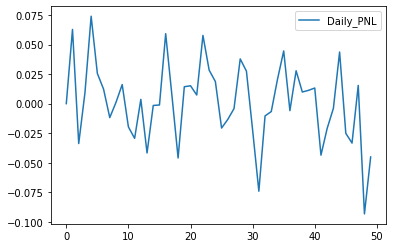

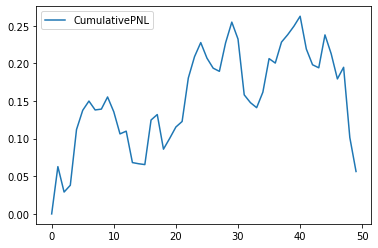

In [185]:
Momemtum_Cummulative_Portfolio_PNL = pd.DataFrame(Cumulative_PNL,columns = {"CumulativePNL"})
Momemtum_Daily_Portfolio_PNL = pd.DataFrame(Daily_PNL,columns = {"Daily_PNL"})
Momemtum_Daily_Portfolio_PNL.plot() 
Momemtum_Cummulative_Portfolio_PNL.plot()